In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [24]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [25]:
EPOCHS = 20
BATCH_SIZE = 64

In [26]:
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [27]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

In [28]:
train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE
)

In [29]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

(224, 224, 3)


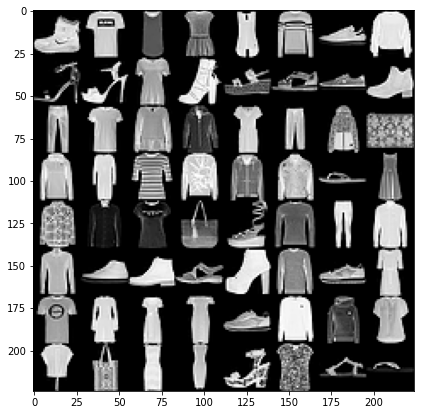

In [30]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(7, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
print(np.transpose(npimg, (1,2,0)).shape)
plt.show()

In [31]:
for i, label in enumerate(labels):
    print("{}".format(label.item()), end=' ')
    if i % 8 == 7:
        print()

9 0 0 3 0 2 7 2 
5 5 0 9 5 5 7 9 
1 0 6 4 3 1 4 8 
4 3 0 2 4 4 5 3 
6 6 0 8 5 2 1 6 
6 7 9 5 9 2 7 3 
0 3 3 3 7 2 2 6 
6 8 3 3 5 0 5 5 


In [32]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


for i, label in enumerate(labels):
    index = label.item()
    print("{:12}".format(CLASSES[index]), end=' ')
    if i % 8 == 7:
        print()

Ankle boot   T-shirt/top  T-shirt/top  Dress        T-shirt/top  Pullover     Sneaker      Pullover     
Sandal       Sandal       T-shirt/top  Ankle boot   Sandal       Sandal       Sneaker      Ankle boot   
Trouser      T-shirt/top  Shirt        Coat         Dress        Trouser      Coat         Bag          
Coat         Dress        T-shirt/top  Pullover     Coat         Coat         Sandal       Dress        
Shirt        Shirt        T-shirt/top  Bag          Sandal       Pullover     Trouser      Shirt        
Shirt        Sneaker      Ankle boot   Sandal       Ankle boot   Pullover     Sneaker      Dress        
T-shirt/top  Dress        Dress        Dress        Sneaker      Pullover     Pullover     Shirt        
Shirt        Bag          Dress        Dress        Sandal       T-shirt/top  Sandal       Sandal       


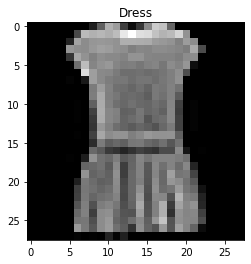

In [33]:
idx = 3

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap='gray')
plt.show()

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))
        # x = F.softmax(self.fc3(x))
        x = self.fc3(x)  # [120, 5, 7, 15, 20, ...] -> softmax -> [0.8, 0.01, 0.05, ..]
        # 예측값 -> [0.8, 0.01, 0.05, ..]
        # labels -> [9, 3, 1, ...]
        # [9, 3, 1, ...] -> [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        #                    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        #                     ....]
        # Label -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        return x

In [35]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

In [36]:
data_idx = 0
input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE)
target = torch.tensor([testset[data_idx][1]]).to(DEVICE)
output = model(input_img)

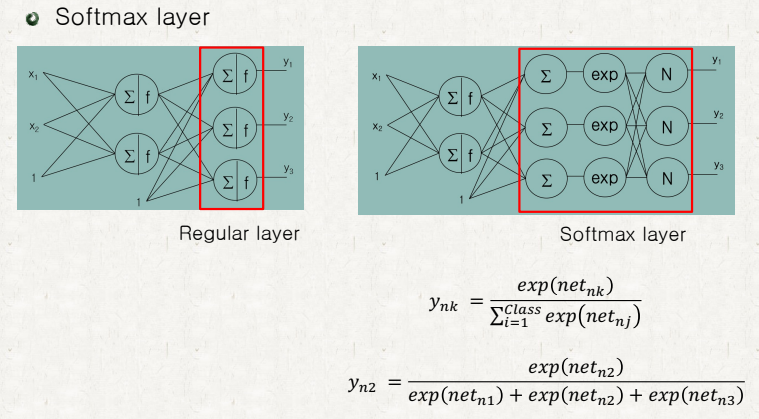

In [37]:
output = output.squeeze(dim=0)
output.shape

torch.Size([10])

In [38]:
torch.exp(output.squeeze(dim=0)) / torch.exp(output.squeeze(dim=0)).sum()

tensor([0.0953, 0.1006, 0.1024, 0.0874, 0.0946, 0.1094, 0.1033, 0.1048, 0.0955,
        0.1067], device='cuda:0', grad_fn=<DivBackward0>)

In [39]:
F.softmax(output.squeeze(dim=0), dim=0) # 위 셀과 같게 출력되는 것 확인

tensor([0.0953, 0.1006, 0.1024, 0.0874, 0.0946, 0.1094, 0.1033, 0.1048, 0.0955,
        0.1067], device='cuda:0', grad_fn=<SoftmaxBackward>)

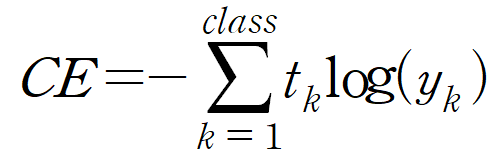

In [42]:
target

tensor([9], device='cuda:0')

In [43]:
-torch.log(F.softmax(output.squeeze(dim=0), dim=0)[9])

tensor(2.2379, device='cuda:0', grad_fn=<NegBackward>)

In [44]:
F.cross_entropy(output.unsqueeze(dim=0), target) # 위 셀과 같게 출력되는 것 확인

tensor(2.2379, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(dim=1)[1]  # (max value, argmax) (batch * 10)
            # pred => [5, 7, 0, 1, 9, ..]
            correct += pred.eq(target).sum().item()  # [True, False, True, ...]

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

In [ ]:
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

In [ ]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss
        pred = output.max(dim=1)[1]
        correct += pred.eq(target).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(dim=1)[1]  # (max value, argmax) (batch * 10)
            # pred => [5, 7, 0, 1, 9, ..]
            correct += pred.eq(target).sum().item()  # [True, False, True, ...]

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(1, EPOCHS+1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)


    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

In [ ]:
plt.plot(train_loss_list, color = 'b')
plt.plot(test_loss_list, color = 'orange')
plt.show()

In [ ]:
plt.plot(train_accuracy_list, color = 'b')
plt.plot(test_accuracy_list, color = 'orange')
plt.show()